In [89]:
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import datetime
import requests
import re

In [92]:
# Function to grab video details from API and store them into a json.
def scrapeData():
    # Prepare the output file for appending new data
    outputFile = open('TiktokData.json', 'a', encoding='utf-8')
    #Connect to api
    url = "https://tiktok-api23.p.rapidapi.com/api/post/trending"
    headers = {
        "X-RapidAPI-Key": "b914b9089amsh57d0a4103d72072p1b9c18jsna3a7dd730f95",
        "X-RapidAPI-Host": "tiktok-api23.p.rapidapi.com"
    }

    querystring = {"count": "30"}
    response = requests.get(url, headers=headers, params=querystring)
    jsonData = response.json()

    for item in jsonData["itemList"]:
        videoId = item["id"]
        hashtags = re.findall(r'#\w+', item['desc'])  # Extract hashtags from description.
        if hashtags and all(re.match(r'^#[A-Za-z0-9_]+$', tag) for tag in hashtags):
            videoDetails = {
                "videoId": videoId,
                "likes": item["stats"]["diggCount"],
                "followerCount": item["authorStats"]["followerCount"],
                "hashtags": hashtags,
                "createDate": datetime.fromtimestamp(item["createTime"]).strftime('%Y-%m-%d %H:%M:%S')
            }
            outputFile.write(json.dumps(videoDetails) + '\n')

    print("Data extraction and saving process completed.")

# Function to convert timestamps into day of the week and hour of the day
def get_datetime(time_stamp):
    date = datetime.datetime.strptime(time_stamp,'%Y-%m-%d %H:%M:%S')
    weekday = date.weekday()
    hour = date.hour + date.minute/60 # Convert time to decimal hours
    return weekday,hour

# Function to prepare data i.e remove duplicates
def prepare_data():
    with open('TiktokData.json','r') as json_file:
        json_list = list(json_file)
    json_file.close()

    video_list = []
    video_set = set()
    # Filter and collect unique videos
    for json_str in json_list:
        video = json.loads(json_str)
        videoID = video['videoId']
        if videoID not in video_set:
            video_list.append(video)
            video_set.add(videoID)

    # Extract followers, likes, and timestamps
    followers = np.array([video['followerCount'] for video in video_list])
    likes = np.array([video['likes'] for video in video_list])
    time_stamps = np.array([get_datetime(video['createDate']) for video in video_list])

    # Process hashtags into a single string per video and vectorize
    # Convert textual to numeric values
    hashtags = []
    for video in video_list:
        hashtags.append(' '.join(video['hashtags']))

    countvec = CountVectorizer(strip_accents='ascii',ngram_range = (1,1))
    count_data = countvec.fit_transform(hashtags).toarray()

    # Combine all features into a feature matrix
    features = np.c_[followers, time_stamps, count_data]
    df = pd.DataFrame(features)
    X = features

    # Create a binary target variable based on likes-to-followers ratio
    ratio = likes/followers
    y = np.where(ratio > 10,1,0)
    y = np.where(np.logical_and(likes>1e4,ratio>10),1,0)
    return X,y

# Function to find the optimal k value for KNN
def choose_k(X, y, plot_results=True):
    '''
    Determines the optimal number of neighbors (k) for the K-Nearest Neighbors (KNN) classifier
    based on the accuracy of predictions on training and testing data sets.

    This function evaluates a range of k values starting from 1 to an upper limit determined by the
    square root of the number of samples plus 20. It iterates through odd k values to avoid ties
    in voting. For each k value, it trains a KNN classifier and calculates the accuracy on both
    the training and testing sets.

    It also plots the results, showing how the accuracy varies with different
    k values, which helps in visualizing the trade-off between overfitting and underfitting.

    Looking at the convergance we can see that a k value of 15 is ideal
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)
    n_samples = len(y)
    k_guess = int(np.sqrt(n_samples))
    kmax = k_guess + 20
    test_scores = []
    train_scores = []
    for k in range(1,kmax,2):
        KNN = KNeighborsClassifier(n_neighbors=k)
        KNN = KNN.fit(X_train,y_train)
        y_pred = KNN.predict(X_test)
        test_score = accuracy_score(y_test,y_pred)
        train_score = accuracy_score(y_train,KNN.predict(X_train))
        test_scores.append(test_score)
        train_scores.append(train_score)

    if plot_results:
        krange = range(1,kmax,2)
        plt.plot(krange,test_scores,'--',label='Test Accuracy')
        plt.plot(krange,train_scores,label='Train Accuracy')
        plt.title('k Optimization')
        plt.xlabel('k value')
        plt.ylabel('Accuracy')
        plt.legend()
    return

def choose_k_silhouette(X, y, plot_results=True):
    """
    Determines the optimal number of neighbors (k) for the K-Nearest Neighbors (KNN) classifier
    based on the silhouette score of predictions on training and testing data sets.

    This function evaluates a range of k values starting from 1 to an upper limit determined by the
    square root of the number of samples plus 20. It iterates through odd k values to avoid ties
    in voting. For each k value, it trains a KNN classifier and calculates the silhouette score
    on the testing set.

    Optionally, the function can plot the results, showing how the silhouette score varies with
    different k values, which helps in visualizing the clustering performance of the model.

    Parameters:
        X (array-like): Feature matrix for the classifier.
        y (array-like): Target vector, corresponding to the labels of the observations in X.
        plot_results (bool, optional): If True, the function plots the silhouette scores against
                                       the k values and labels the maximum value. Default is True.

    Returns:
        None: The function does not return any value but displays a plot of silhouette scores if
              plot_results is set to True.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    n_samples = len(y)
    k_guess = int(np.sqrt(n_samples))
    kmax = k_guess + 20
    silhouette_scores = []

    for k in range(1, kmax, 2):
        KNN = KNeighborsClassifier(n_neighbors=k)
        KNN.fit(X_train, y_train)
        labels = KNN.predict(X_test)
        # Calculate the silhouette score, ensure there are at least 2 clusters to calculate
        if len(set(labels)) > 1:
            score = silhouette_score(X_test, labels)
            silhouette_scores.append(score)
        else:
            silhouette_scores.append(-1)  # Not enough clusters to evaluate silhouette score

    if plot_results:
        krange = list(range(1, kmax, 2))
        max_score = max(silhouette_scores)
        max_k = krange[silhouette_scores.index(max_score)]

        plt.figure(figsize=(10, 5))
        plt.plot(krange, silhouette_scores, marker='o', label='Silhouette Score')
        plt.scatter(max_k, max_score, color='red', s=100, label=f'Max Score {max_score:.2f} at k={max_k}')
        plt.title('KNN Silhouette Score Optimization')
        plt.xlabel('k value')
        plt.ylabel('Silhouette Score')
        plt.xticks(krange)
        plt.grid(True)
        plt.legend()
        plt.show()

    return

# Function to evaluate prediction performance
def evaluate_prediction(X, y, k):
    """
    Trains a K-Nearest Neighbors (KNN) classifier using a specified number of neighbors (k)
    and evaluates its performance on a test dataset. The function splits the input dataset
    into training and testing sets, trains the KNN classifier, and then computes the
    accuracy of the model along with producing a classification report and a confusion
    matrix.

    Returns a tuple containing:
          - The trained KNN model (KNeighborsClassifier object).
          - Accuracy score (float) of the model on the test data.
          - Classification report (str) summarizing the main classification metrics.
          - Confusion matrix (array), showing the actual vs predicted classifications.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN = KNN.fit(X_train,y_train)
    y_pred = KNN.predict(X_test)
    test_score = accuracy_score(y_test,y_pred)
    acc = accuracy_score(y_test,y_pred)
    report = classification_report(y_test,y_pred)
    conf = confusion_matrix(y_test,y_pred)

    return KNN,acc,report,conf

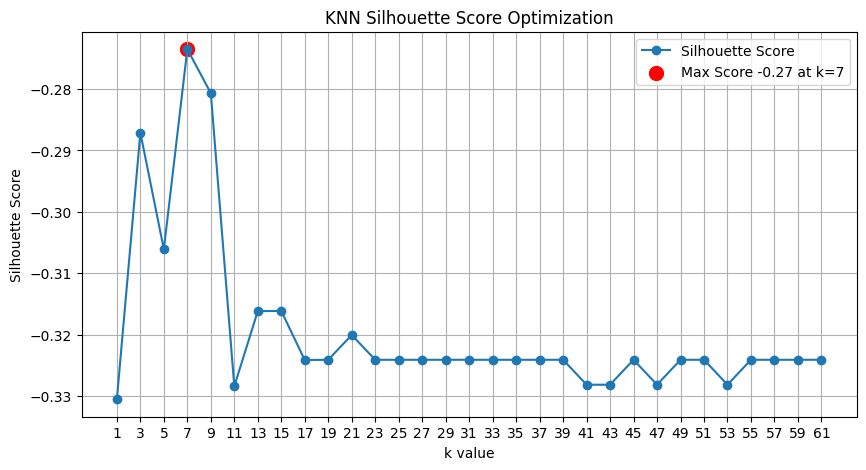

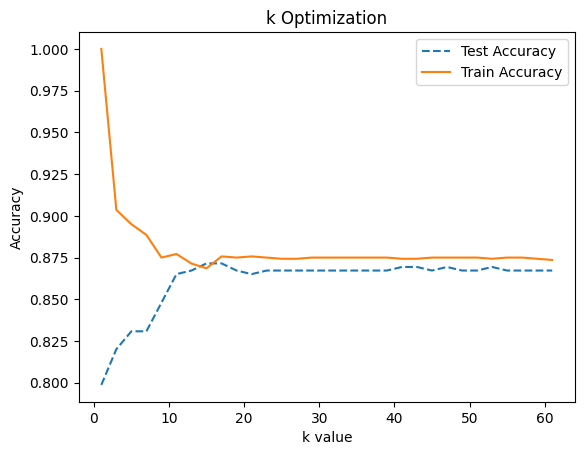

In [93]:
X,y = prepare_data()
choose_k_silhouette(X, y)
choose_k(X, y)

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       380
           1       0.71      0.58      0.64       110

    accuracy                           0.85       490
   macro avg       0.80      0.76      0.77       490
weighted avg       0.85      0.85      0.85       490



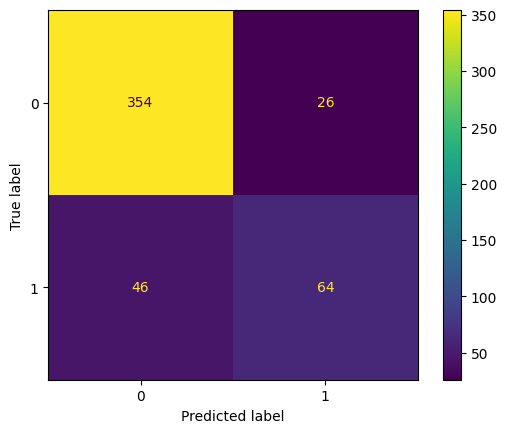

In [84]:
# Evaluate the model performance
KNN, acc, report, conf = evaluate_prediction(X,y,15)
# print('Accuracy Score: {}\n'.format(round(acc,3)))
print(report)
disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels = KNN.classes_)
disp.plot()
plt.show()


0.23281143635125937
0.18775510204081633
0.8938775510204081
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       398
           1       0.73      0.70      0.71        92

    accuracy                           0.89       490
   macro avg       0.83      0.82      0.82       490
weighted avg       0.89      0.89      0.89       490

[[374  24]
 [ 28  64]]


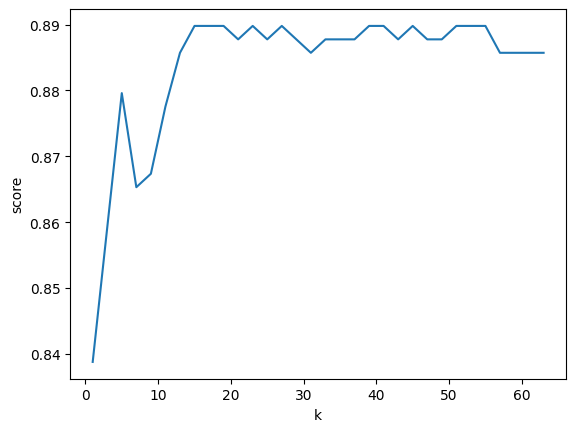

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)

print(sum(y_train)/len(y_train))
print(sum(y_test)/len(y_test))

n_samples = len(y)
kmid = int(np.sqrt(n_samples))

scores = []
kmin = 1
kmax = kmid + 20
for k in range(kmin,kmax,2):
    #Train KNN
    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN = KNN.fit(X_train,y_train)

    #Test KNN
    scores.append(KNN.score(X_test,y_test))

plt.plot(range(kmin,kmax,2),scores)
plt.ylabel('score')
plt.xlabel('k')

KNN = KNeighborsClassifier(n_neighbors=18)
KNN = KNN.fit(X_train,y_train)

y_pred = KNN.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

In [86]:
from sklearn import tree
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    random_state=0)

clf = tree.DecisionTreeClassifier() # Initialize decision tree classifier
clf.fit(X_train,y_train) # Fit model to train data
ypred = clf.predict(X_test) # Use model to predict test data
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.6612244897959184
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       382
           1       0.17      0.14      0.15       108

    accuracy                           0.66       490
   macro avg       0.47      0.47      0.47       490
weighted avg       0.64      0.66      0.65       490

[[309  73]
 [ 93  15]]
